In [1]:
from ccxt import binance
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

import csv
import mplfinance as mpf
from talib import RSI,MACD
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


# binance =  ccxt.binance({'proxies': {
#         'http': '127.0.0.1:7890',
#         'https': '127.0.0.1:7890',
#     }})
binance =  ccxt.binance({'apiKey': 'r7gNZ2EBDHtM2OPUZWbgDIkHlvL2pQZyKRJIungEL6ycdet208UWSSG1v6IsKjVJ','secret': 'nixwAznLC0xKeeX1L7uHuQp8PbLYvsH3pPEjxj7gnZ6FYkS1OtM3lRMXLE0YwX5l'})


NameError: name 'ccxt' is not defined

In [9]:
start = 1721425159000
kline = pd.DataFrame()
while True:
    new = pd.DataFrame(binance.fapipublicGetKlines({'symbol':'BTCUSDT','limit':1500,'interval':'1m','startTime':start}),columns=['Open Time','open','high','low','close','volume','Close Time','Quote Asset Volume','trades','tbv','Taker Buy u Volume','Ignore'])
    
    kline = pd.concat([kline,new], ignore_index=True)
    start = kline.iloc[-1]['Close Time']
    if len(new) < 1500:
        break
data =kline[['Open Time','open','high','low','close','volume','trades','tbv']]
data['Open Time'] = pd.to_datetime(data['Open Time'], unit='ms')
data.set_index('Open Time', inplace=True)
data['hour'] = data.index.hour
data=data.astype(float)
data.info()
data.to_csv('币安.csv')

C:\Users\sherr\AppData\Local\Temp\ipykernel_13240\1082992747.py:11: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['Open Time'] = pd.to_datetime(data['Open Time'], unit='ms')
C:\Users\sherr\AppData\Local\Temp\ipykernel_13240\1082992747.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Open Time'] = pd.to_datetime(data['Open Time'], unit='ms')
C:\Users\sherr\AppData\Local\Temp\ipykernel_13240\1082992747.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 149772 entries, 2024-07-19 21:39:59.104000 to 2024-10-31 21:51:35.424000
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    149772 non-null  float64
 1   high    149772 non-null  float64
 2   low     149772 non-null  float64
 3   close   149772 non-null  float64
 4   volume  149772 non-null  float64
 5   trades  149772 non-null  float64
 6   tbv     149772 non-null  float64
 7   hour    149772 non-null  float64
dtypes: float64(8)
memory usage: 10.3 MB


In [15]:
## 网格回测

# 加载历史价格数据
# 假设数据包含两列：日期 (Date) 和 收盘价 (Close)
# 示例数据可以是 'historical_data.csv'
data = pd.read_csv('币安.csv', parse_dates=['Open Time'], index_col=0)
prices = data['close']


In [ ]:

# 初始参数
initial_balance = 10000  # 初始资金
grid_size = 10           # 网格数量
lower_bound = prices.min()  # 网格下界
upper_bound = prices.max()  # 网格上界
fee = 0.00018             # 手续费
beginning_price = prices.iloc[0]  # 开盘价
grid_interval = (upper_bound-lower_bound)/grid_size       # 网格间距
grid_positions = [lower_bound + i * grid_interval for i in range(grid_size + 1)]
qty = round(10000/grid_size/prices.mean(),3)  # 买入数量

# 初始化变量
balance = initial_balance
positions = 0
grid_balance_history = []  # 记录每个时间点的总资金

# 回测逻辑
for price in prices:
    # 如果当前价格低于某个网格位置,多头操作：开多和平空
    if price < beginning_price:
        for grid_price in grid_positions:
            if grid_price >= beginning_price:
                break
            if price <= grid_price: 
                if positions >= 0 and balance >= grid_price*qty or positions < 0:
                    # 开多
                    balance -= qty * grid_price * (1 + fee) 
                    positions += qty
                    print(f"买入: {qty}份，价格: {price}，网格价格: {grid_price}, 基准价: {beginning_price}")
                    beginning_price = grid_price
                    break


    # 如果当前价格高于某个网格位置,空头操作：开空和平多
    if price > beginning_price:
        for grid_price in reversed(grid_positions):
            if grid_price <= beginning_price:
                break
            if price >= grid_price :
                if positions > 0 or positions<=0 and balance >= grid_price*qty:
                    # 平多
                    balance += qty * grid_price * (1 - fee) 
                    print(f"卖出: {qty}份，价格: {price}，网格价格: {grid_price}, 基准价: {beginning_price}")
                    positions -= qty
                    beginning_price = grid_price
                    break


    # 记录每日的资金价值 (balance + 当前持仓价值)
    grid_balance_history.append(balance + positions * price)


买入: 0.016份，价格: 66298.8，网格价格: 66319.02, 基准价: 67025.4
买入: 0.016份，价格: 63875.0，网格价格: 63895.36, 基准价: 66319.02
卖出: 0.016份，价格: 66421.9，网格价格: 66319.02, 基准价: 63895.36
卖出: 0.016份，价格: 68832.5，网格价格: 68742.68, 基准价: 66319.02
买入: 0.016份，价格: 66120.7，网格价格: 66319.02, 基准价: 68742.68
买入: 0.016份，价格: 63890.0，网格价格: 63895.36, 基准价: 66319.02
买入: 0.016份，价格: 61272.5，网格价格: 61471.7, 基准价: 63895.36
买入: 0.016份，价格: 59021.8，网格价格: 59048.04, 基准价: 61471.7
买入: 0.016份，价格: 56478.1，网格价格: 56624.380000000005, 基准价: 59048.04
买入: 0.016份，价格: 52945.9，网格价格: 54200.72, 基准价: 56624.380000000005
买入: 0.016份，价格: 51675.3，网格价格: 51777.06, 基准价: 54200.72
买入: 0.016份，价格: 49353.4，网格价格: 49353.4, 基准价: 51777.06
卖出: 0.016份，价格: 51777.9，网格价格: 51777.06, 基准价: 49353.4
卖出: 0.016份，价格: 54441.9，网格价格: 54200.72, 基准价: 51777.06
卖出: 0.016份，价格: 56632.8，网格价格: 56624.380000000005, 基准价: 54200.72
卖出: 0.016份，价格: 59085.7，网格价格: 59048.04, 基准价: 56624.380000000005
卖出: 0.016份，价格: 61474.0，网格价格: 61471.7, 基准价: 59048.04
买入: 0.016份，价格: 59038.8，网格价格: 59048.04, 基准价: 61471.7
卖出: 0.016份，价格

总收益率: 9.34%


C:\Users\sherr\AppData\Local\Temp\ipykernel_13240\1624358449.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = (backtest_results['Total Balance'][-1] - initial_balance) / initial_balance


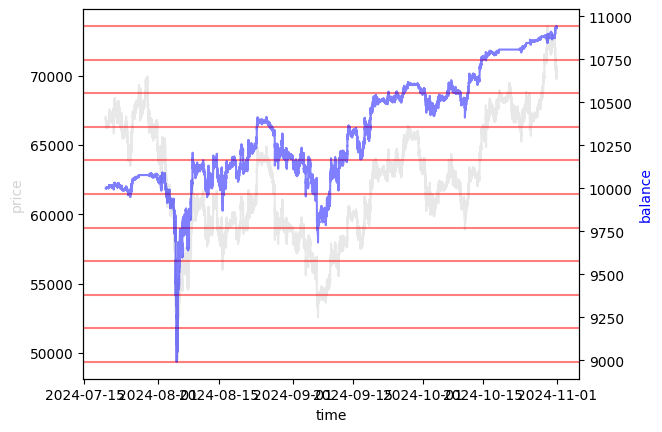

In [83]:

# 将资金历史保存为DataFrame，方便计算回测指标
backtest_results = pd.DataFrame({
    'Date': prices.index,
    'Total Balance': grid_balance_history
}).set_index('Date')

# 计算回测收益指标
total_return = (backtest_results['Total Balance'][-1] - initial_balance) / initial_balance
print(f"总收益率: {total_return:.2%}")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(prices.index, prices, 'lightgray',alpha=0.5)
ax2.plot(prices.index, backtest_results['Total Balance'], 'b', alpha=0.5)

ax1.set_xlabel('time')
ax1.set_ylabel('price', color='lightgray')
ax2.set_ylabel('balance', color='b')
for grid in grid_positions:
    ax1.axhline(grid, color='r', alpha=0.5)

plt.show()


C:\Users\sherr\AppData\Roaming\Python\Python311\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


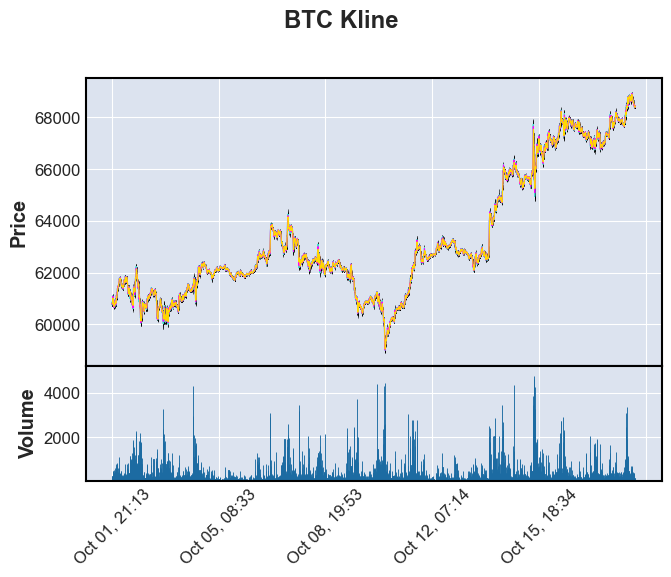

In [6]:
mpf.plot(data,type='candle',mav=(5,10,20),volume=True,title='BTC Kline')

分类准确率: 0.50


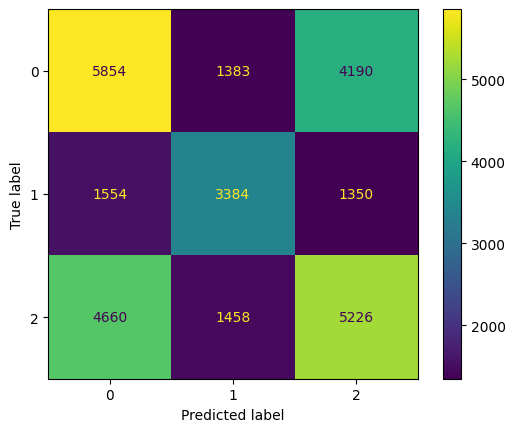

In [3]:
# 特征工程
data = pd.read_csv('币安.csv',index_col=0)
# 标准化 trades
data['trades'] = data['trades']/data['trades'].max()
data['SMA_10'] = data['close'].rolling(window=10).mean()-data['close']
data['SMA_20'] = data['close'].rolling(window=20).mean()-data['close']
data['o2l'] = data['open'] / data['low']-1
data['h2l'] = data['high'] / data['low']-1
data['o2h'] = data['open'] / data['high']-1
data['h2c'] = data['high'] / data['close']-1
data['l2c'] = data['low'] / data['close']-1
data['max_price_5'] = data['high'].rolling(window=10).max()
data['min_price_5'] = data['low'].rolling(window=10).min()
data['max_price_diff'] = data['max_price_5']/data['close']-1
data['min_price_diff'] = data['min_price_5']/data['close']-1
data['price_std'] = data['close'].rolling(window=10).std()
data['volume_std'] = data['volume'].rolling(window=10).std()
data['return'] = data['close'].pct_change()
data['momt'] = data['return']/data['volume']
data['rsi'] = RSI(data['close'], timeperiod=10)
data['macd'], data['macdsignal'], data['macdhist'] = MACD(data['close'], fastperiod=10, slowperiod=20, signalperiod=3)
data['vpt'] = data['volume']/data['trades']
# 标签生成：1为涨，0为跌
# data['label'] = np.where(data['high'].shift(-1)/data['close']-1 >= 0.0008, 1, 0)
# 标签生成：1为涨, 0为平，-1为跌
data['next_high'] = data['max_price_5'].shift(-10)
data['next_low'] = data['min_price_5'].shift(-10)
data.dropna(inplace=True)
def labeling(data):
    raising = data['next_high']/data['close']-1 
    falling = data['next_low']/data['close']-1
    buy = raising > -falling
    if not buy and falling <= -0.001:
        return -1
    elif buy and raising >= 0.001:
        return 1
    else:
        return 0
data['label'] = data.apply(labeling, axis=1)
data.drop(['next_high','next_low','max_price_5','min_price_5'], axis=1,inplace=True)

# 去掉NaN数据
data.dropna(inplace=True)

# 分割数据集
X = data.drop(['label','open','high','low'], axis=1)  # 输入特征
y = data['label']  # 输出标签
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=92)

# 构建随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 测试模型
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'分类准确率: {accuracy:.2f}')
cm=confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()


In [4]:
pos=cm[0][0]+cm[2][2]
neg=cm[0][2]+cm[2][0]
pos/(pos+neg),neg/(pos+neg)

(0.5559458103361766, 0.4440541896638234)

In [88]:
X_test['pred'] = y_pred
pd.concat([X_test, y_test], axis=1).to_csv('result.csv', index=False)

In [120]:
g=pd.concat([X_test, y_test], axis=1).groupby('label')['label'].count()
print(g.sum(),g/g.sum())
g=data.groupby('label')['label'].count()
g.sum(),g/g.sum(),np.unique(y_pred, return_counts=True)


5169 label
-1    0.356936
 0    0.277230
 1    0.365835
Name: label, dtype: float64


(25845,
 label
 -1    0.356936
  0    0.274831
  1    0.368234
 Name: label, dtype: float64,
 (array([-1,  0,  1], dtype=int64), array([1836, 1587, 1746], dtype=int64)))

In [5]:
importances = model.feature_importances_
feat_labels = X.columns
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) trades                         0.064038
 2) price_std                      0.056190
 3) close                          0.053191
 4) volume_std                     0.052693
 5) h2l                            0.052467
 6) volume                         0.048737
 7) max_price_diff                 0.046367
 8) tbv                            0.046082
 9) min_price_diff                 0.045935
10) rsi                            0.044372
11) vpt                            0.042172
12) SMA_20                         0.041759
13) macdsignal                     0.041047
14) macdhist                       0.040689
15) macd                           0.040663
16) SMA_10                         0.040374
17) l2c                            0.036301
18) return                         0.036142
19) h2c                            0.035865
20) hour                           0.035175
21) o2h                            0.034597
22) o2l                            0.034516
23) momt                        

In [2]:
#最近三天平均资金费率为正的
days = 3
def fetchBnList():
    # 现货list
    spot = pd.DataFrame(binance.publicGetExchangeInfo()['symbols'])
    spot = spot[spot['quoteAsset']=='USDT']['symbol']
    # 期货list
    swap = pd.DataFrame(binance.fapiPublicGetExchangeInfo()['symbols'])
    swap.to_csv('binance_swap.csv', index=False)
    swap = swap[swap['quoteAsset']=='USDT']['symbol']
    return spot[spot.isin(swap)].to_list()
    # list.to_csv('binance_list.csv', index=False)
coins = fetchBnList()
rates = pd.DataFrame()
blacklist = ['IDEXUSDT','SLPUSDT','GLMRUSDT','MDTUSDT','AUDIOUSDT','RADUSDT','CVXUSDT','ETCUSDT','ATAUSDT','PENDLEUSDT','ARUSDT','ARPAUSDT','BAKEUSDT','RNDRUSDT','KLAYUSDT']
for coin in coins:
    if coin in blacklist:
        continue
    try:
        ret = pd.DataFrame(binance.fapiPublicGetFundingRate({'symbol':coin,'limit':days*3}))
        rates = pd.concat([rates,ret])
    except:
        pass
rates['fundingRate']=rates['fundingRate'].astype(float)
means = rates.groupby(by='symbol')['fundingRate'].mean()
feeOk = means[means>=0.00011].reset_index()['symbol'].apply(lambda x: '\"'+x.split('USDT')[0]+'-USDT-SWAP",')
feeOk.to_csv('FeeOk.csv',index=False,header=False,quoting=csv.QUOTE_NONE,escapechar=' ')
feeOk = means[means>=0.0001].reset_index()['symbol'].apply(lambda x: '\"'+x.split('USDT')[0]+'-USDT-SWAP",')
feeOk.to_csv('FeeOk.csv',index=False,header=False,quoting=csv.QUOTE_NONE,escapechar=' ')
orders['slipage'] = orders.apply(lambda x: 0 if 'Clear' in x['cid'] or x['slipage']>0.01 or x['slipage']<-0.01 else x['slipage'],axis=1)
orders['netValue'] = orders.apply(lambda x: x['value'] if str.upper(x.side)=='SELL' else -x['value'],axis=1)
orders['netQty'] = orders.apply(lambda x: x['qty'] if str.upper(x.side)=='BUY' else -x['qty'],axis=1)
orders.fillna('',inplace=True)
orders['symbol'] = orders['xSymbol']+orders['ySymbol']
summary = orders.groupby(['symbol']).agg({'netValue':'sum','value':'sum','netQty':'sum','qty':'sum','slipage':'mean','avgPrice':'mean'}).sort_values('slipage')
summary['unhedgedValue'] = summary['netQty']*summary['avgPrice']
summary['slipageValue'] = summary['slipage']*summary['value']
summary['totalValue'] = summary['unhedgedValue'] + summary['netValue']
summary.head(30)[['totalValue','slipageValue','slipage']]
